# Przygotowanie danych - Mikołaj Pacek, Karol Mierzwiński

In [351]:

from sympy import Integer
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import hashlib

Basic import and usage

In [352]:
#url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/reduced_dataset_sdn.csv'
url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/dataset_sdn.csv'
s = requests.get(url).content

counters = pd.read_csv(io.StringIO(s.decode('utf-8')))
counters.dt = pd.to_datetime(counters.dt, unit='s')
#counters.set_index('dt', inplace=True)
counters

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,1970-01-01 03:10:25,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,1970-01-01 03:13:25,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,1970-01-01 01:27:42,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,1970-01-01 01:27:42,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


Visualization of UDP Data

<ipython-input-353-1385ee0cde35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  udp_data['log_bytecount'] = np.log(udp_data['bytecount'] + 1)


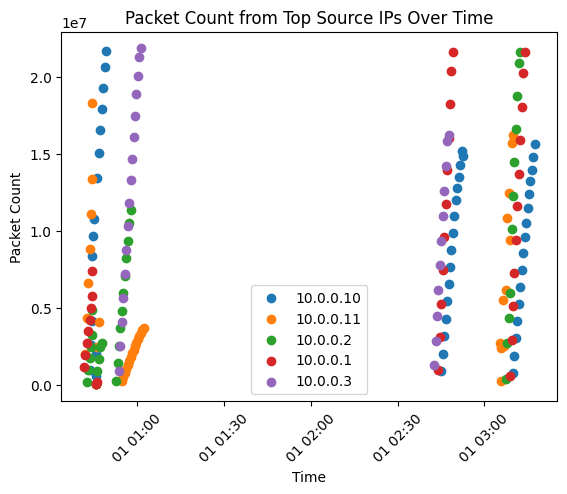

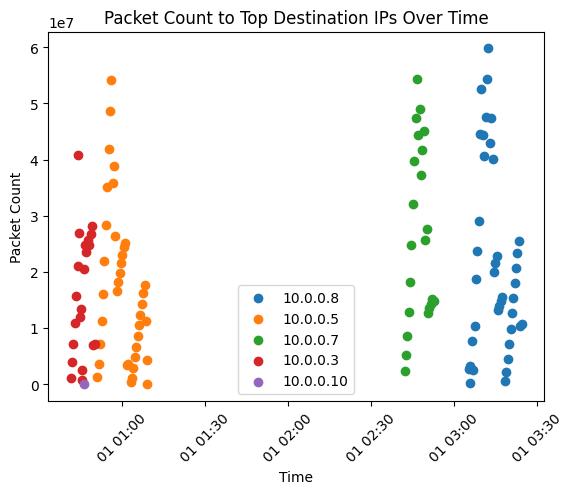

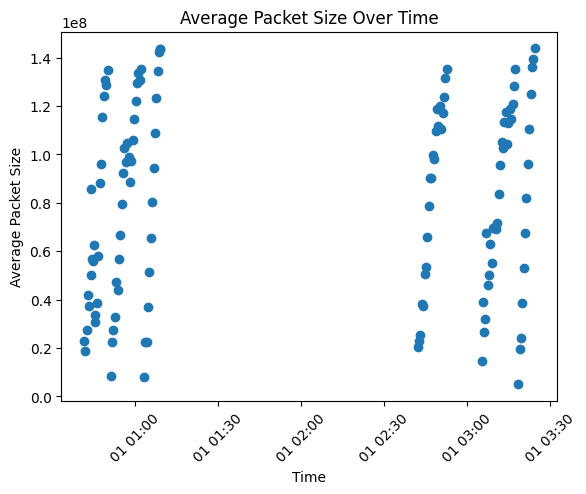

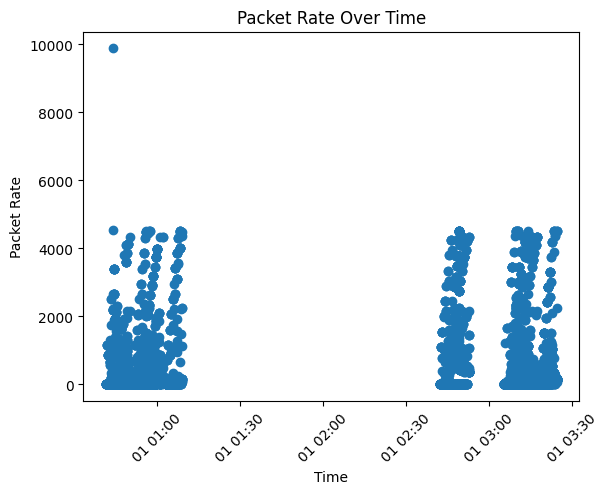

In [353]:
udp_data = counters[counters['Protocol'] == 'UDP']
udp_data['log_bytecount'] = np.log(udp_data['bytecount'] + 1)

# 1. Source IP Count
src_ip_pkt_count = udp_data.groupby(['dt', 'src'])['pktcount'].sum().reset_index()
top_src_ips = src_ip_pkt_count['src'].value_counts().index[:5]
for ip in top_src_ips:
    ip_data = src_ip_pkt_count[src_ip_pkt_count['src'] == ip]
    plt.scatter(ip_data['dt'], ip_data['pktcount'], label=ip)

plt.title('Packet Count from Top Source IPs Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 2. Destrination IP Count
dst_ip_pkt_count = udp_data.groupby(['dt', 'dst'])['pktcount'].sum().reset_index()

# Now, let's plot the top 5 destination IPs that received the most packets
top_dst_ips = dst_ip_pkt_count['dst'].value_counts().index[:5]

for ip in top_dst_ips:
    ip_data = dst_ip_pkt_count[dst_ip_pkt_count['dst'] == ip]
    plt.scatter(ip_data['dt'], ip_data['pktcount'], label=ip)

plt.title('Packet Count to Top Destination IPs Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 3. Average Packet Size
avg_pkt_size = udp_data.groupby('dt')['bytecount'].mean()
plt.scatter(avg_pkt_size.index, avg_pkt_size)
plt.title('Average Packet Size Over Time')
plt.xlabel('Time')
plt.ylabel('Average Packet Size')
plt.xticks(rotation=45)

plt.show()

# 4. Packet Rate
pkt_rate = udp_data['pktcount'].div(udp_data['dt'].diff().dt.seconds).fillna(0)
plt.scatter(udp_data['dt'], pkt_rate)
plt.title('Packet Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Rate')
plt.xticks(rotation=45)

plt.show()



## Przygotowanie danych – brakujące dane

Usunięcie całych obserwacji w których występuje brak danych. Często metodę określa się z angielskiego jako complete-case analysis (CCA), czyli analizie poddajemy tylko te obserwacje dla których mamy pełne dane dla wszystkich zmiennych. W naszym przypadku nie posiadamy takich rekordów danych w którym brakowałoby jakichś parametrów.

In [354]:
missing = [var for var in counters.columns if counters[var].isnull().sum() > 0]
missing

['rx_kbps', 'tot_kbps']

## Przygotowanie danych - kodowanie zmiennych kategorialnych

Dla przypomnienia zmienna kategorialna to taka, która pozwala na przeprowadzenie klasyfikacji serii danych za pomocą wartości związanych z określoną jakością czy kategorią. Zmienna kategorialna pozwala sklasyfikować, pogrupować w oparciu o informację jakościową, czyli najczęściej w danych spotkamy zmienną kategorialną z elementami stanowiącymi łańcuch tekstowy. W naszym przypadku będziemy zaliczać do zmiennych kategorialnych : data/czas danych wpisów, nazwa protokołu jaki został uzyty, destination i source adresy.

Na podstawie róznych benchamrków, mozemy się skupić na tych 4 enkoderach.

"We observed that four encoders: One-Hot, Binary (‘Bin’ on the plot), Sum, and Weight of Evidence are consistently among the best performing. For logistic regression, the difference of these four from the rest is statistically significant."


## Przygotowanie danych - duration

Łączymy duration_sec i duration_nsec, aby otrzymać pełny czas trwania - duration.


In [355]:
# Create the new 'duration' column
counters['duration'] = counters['dur'] + counters['dur_nsec'] / 1e9

# Drop the 'duration_sec' and 'duration_nsec' columns
counters = counters.drop(['dur', 'dur_nsec'], axis=1)


## Hash encoding

Hash encoding to przydatne kodowanie w przypadku dużych zbiorów danych, ponieważ wymaga mniej pamięci niż kodowanie jednokrotne i jest szybsze niż inne techniki kodowania. Kodowanie skrótu odwzorowuje każdą kategorię na unikalną wartość całkowitą w predefiniowanym zakresie przy użyciu funkcji skrótu . Mogą jednak wystąpić kolizje prowadzące do zmniejszenia wydajności modelu. My w naszym przypadku, będziemy hashować adresy ip używając hasha SHA256.

In [356]:

src_encoded = counters['src'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))
counters['src'] = src_encoded


dst_encoded = counters['dst'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))
counters['dst'] = src_encoded

print(type(counters['src'][0]))





<class 'int'>


## Kodowanie One-Hot Encoding/DummyVariable Encoding

Dla zmiennych kategorialnych bez uporządkowania kodowanie numeryczne, a więc określające relację między kategoriami może prowadzić do niewłaściwego działania uczonego modelu. Wymuszenie uporządkowania, tak jak zrobiliśmy to poprzednio też nie jest dobrym rozwiązaniem. Dla takich przypadków stosuje się kodowanie One-Hot Encoding, które w języku polskim określa się jako kodowanie „1 z n”. Poniewaz dane wypisane powyzej mają mieć tylko postać rozróznienia kategorii / grup osoób, skorzystamy z tego kodowanie. W naszym wypadku występuje jednak problem ilości róznych kategorii w odniesieniu do adresów IP

In [357]:
# ! jak cos to to jest tescik bo nwm czm pokazuje mi ograniczony zakres

# Determine categorical variables in the dataset
categorical_variables = [var for var in counters.columns if counters[var].dtype == 'O']

# Let's explore the cardinality in variables (src, dst, Protocol)
categories = {}
for cat_variable in categorical_variables:
    categories[counters[cat_variable].name] = list(counters[cat_variable].unique())

usecols = ['Protocol']

df = counters[usecols]

df = df.fillna(value='missing')

encoded_columns = pd.get_dummies(df, drop_first=False, dtype=int)

counters = pd.concat([counters, encoded_columns], axis=1)

counters.drop(columns=usecols, inplace=True)




## Normalizacja

Normalizacja to proces przekształcania danych wejściowych w taki sposób, aby poprawić wydajność modelu uczącego się. Głównym celem normalizacji jest doprowadzenie danych do jednolitej skali lub rozkładu, co może ułatwić uczenie modelu poprzez zmniejszenie wpływu różnic w zakresach lub jednostkach między różnymi cechami danych.

Istnieje kilka popularnych metod normalizacji danych, takich jak:

Normalizacja min-max: Skaluje wartości cech do zakresu między 0 a 1, wykorzystując minimum i maksimum wartości danej cechy.
Z-score normalization (StandardScaler): Przekształca wartości cech tak, aby miały średnią równą zero i odchylenie standardowe równe jeden.
Normalizacja jednostkowa: Polega na dzieleniu każdej wartości cechy przez normę wektora cechy, co prowadzi do przeskalowania cech do jednostkowego wektora o długości 1.

In [358]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'counters' is your DataFrame
columns_to_normalize = ['pktcount', 'bytecount', 'tx_bytes', 'rx_bytes']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
counters[columns_to_normalize] = scaler.fit_transform(counters[columns_to_normalize])
counters

,dt,switch,src,dst,pktcount,bytecount,tot_dur,flows,packetins,pktperflow,...,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,duration,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,1970-01-01 03:10:25,1,1108245108271806112863518848100079671513901967...,1108245108271806112863518848100079671513901967...,0.174242,0.328245,1.010000e+11,3,1943,13535,...,1.133295e-01,3.090061e-06,0,0.0,0.0,0,100.716,0,0,1
1,1970-01-01 03:13:25,1,1108245108271806112863518848100079671513901967...,1108245108271806112863518848100079671513901967...,0.486123,0.915781,2.810000e+11,2,1943,13531,...,1.035450e-06,2.689292e-06,0,0.0,0.0,0,280.734,0,0,1
2,1970-01-01 03:10:25,1,9198774319483998541402195860639125225801762867...,9198774319483998541402195860639125225801762867...,0.347427,0.654498,2.010000e+11,3,1943,13534,...,9.984414e-07,3.896647e-07,0,0.0,0.0,0,200.744,0,0,1
3,1970-01-01 03:10:25,1,9198774319483998541402195860639125225801762867...,9198774319483998541402195860639125225801762867...,0.347427,0.654498,2.010000e+11,3,1943,13534,...,9.141880e-07,6.420382e-07,0,0.0,0.0,0,200.744,0,0,1
4,1970-01-01 03:10:25,1,9198774319483998541402195860639125225801762867...,9198774319483998541402195860639125225801762867...,0.347427,0.654498,2.010000e+11,3,1943,13534,...,6.976491e-07,2.835669e-06,0,0.0,0.0,0,200.744,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,1970-01-01 01:27:42,3,2385693374452909825108070417993584407159458423...,2385693374452909825108070417993584407159458423...,0.000304,0.000053,8.184200e+10,5,10,29,...,9.985988e-06,1.197664e-05,1,1.0,2.0,0,81.842,1,0,0
104341,1970-01-01 01:27:42,3,2385693374452909825108070417993584407159458423...,2385693374452909825108070417993584407159458423...,0.000304,0.000053,8.184200e+10,5,10,29,...,9.899373e-06,1.396837e-05,1,1.0,2.0,0,81.842,1,0,0
104342,1970-01-01 01:27:42,3,6301589060979460922538519951432213613144112489...,6301589060979460922538519951432213613144112489...,0.000119,0.000021,3.180500e+10,5,10,30,...,6.944994e-07,2.902295e-06,0,0.0,0.0,0,31.805,1,0,0
104343,1970-01-01 01:27:42,3,6301589060979460922538519951432213613144112489...,6301589060979460922538519951432213613144112489...,0.000119,0.000021,3.180500e+10,5,10,30,...,9.985988e-06,1.197664e-05,1,1.0,2.0,0,31.805,1,0,0


In [359]:
print("test")

test
